In [1]:
#Import standard packages for model training

import tensorflow as T
from tensorflow import *
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import *
import numpy as np
import pandas as pd
import sklearn.metrics as SK
from sklearn.metrics import *
import matplotlib.pyplot as plt
import os 
import io
from utils.GPU import *
    
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

  tensorlayer: GPU MEM Fraction 0.900000
Num GPUs Available:  1


In [2]:
#Import train, validation and test sets

training = './data/COVID_classification2/train_fold_1.csv'
validation = './data/COVID_classification2/valid_fold_1.csv'
test = './data/COVID_classification2/test_fold_1.csv'


train_dataset = pd.read_csv(training, delimiter=',', low_memory=False)
val_dataset = pd.read_csv(validation, delimiter=',', low_memory=False)
test_dataset = pd.read_csv(test, delimiter=',', low_memory=False)


train_dataset.head()

,ID,SMILES,Outcome
0,646,CC(=O)NC(CCC(O)=O)C(=O)NCCC1=CC=C(O)C=C1,0.0
1,392,OC(C(C)N)c1ccccc1,0.0
2,394,O=C(Nc1c(C)cccc1C(=O)OC)CN(CC)CC,0.0
3,265,CC(=O)O[Hg]c1ccccc1,0.0
4,395,NCC(O)C1=CC=CC(O)=C1,0.0


In [3]:
#Import atom and bond featurizers

from utils.graphs import *

#select the numb of tasks here

task_start = 2
tasks= 1
task_index = tasks + 2

#Gennerate graphs from SMILES

X_train = graphs_from_smiles(train_dataset.iloc[:,1].values)
y_train = train_dataset.iloc[:,2:task_index].values

X_test = graphs_from_smiles(test_dataset.iloc[:,1].values)
y_test = test_dataset.iloc[:,2:task_index].values

X_val = graphs_from_smiles(val_dataset.iloc[:,1].values)
y_val = val_dataset.iloc[:,2:task_index].values

#Test graph function

molecule = molecule_from_smiles(train_dataset.iloc[8].SMILES)
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (13, 29)
	bond features	 (39, 7)
	pair indices	 (39, 2)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atom_features (InputLayer)     [(None, 29)]         0           []                               
                                                                                                  
 bond_features (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 pair_indices (InputLayer)      [(None, 2)]          0           []                               
                                                                                                  
 message_passing (MessagePassin  (None, 48)          32544       ['atom_features[0][0]',          
 g)                                                               'bond_features[0][0]',      

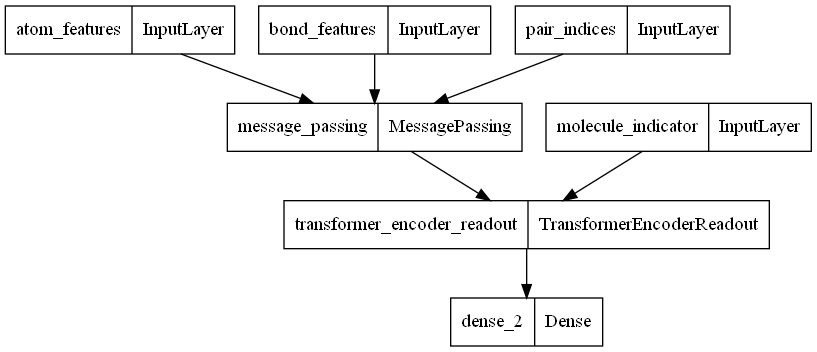

In [4]:
# Import parameters for batch, MPNN, loss and scorers

batch_size =48
dense_units = 50

from utils.batch import *
from utils.MPNN import *
from utils.utils import *


# parameters for train network

def MPNNModel(atom_dim,
    bond_dim,
    batch_size=batch_size,
    message_units=48,
    message_steps=8,
    num_attention_heads=16,
    dense_units=dense_units):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)([atom_features, bond_features, pair_indices])
    x = TransformerEncoderReadout(num_attention_heads, message_units, dense_units, batch_size)([x, molecule_indicator])
    x = layers.Dense(10, activation="sigmoid", kernel_regularizer=T.keras.regularizers.L2(0.05))(x)

    
    model = keras.Model(inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x])
    return model
    


optimizer = RMSprop(0.1, momentum=0.99)
lr_metric = get_lr_metric(optimizer)   

model = MPNNModel(atom_dim=X_train[0][0][0].shape[0], bond_dim=X_train[1][0][0].shape[0])
model.compile(loss = classification_loss(BinaryCrossentropy), metrics=[lr_metric])   
model.summary()
T.keras.utils.plot_model(model)

In [5]:
# Early stopping parameters

train_dataset = MPNNDataset(X_train, y_train, batch_size)
val_dataset = MPNNDataset(X_val, y_val, batch_size)
test_dataset = MPNNDataset(X_test, y_test, batch_size)

callbacks_list = [
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=0.000000001, verbose=1, mode='auto',cooldown=0),
    #ModelCheckpoint(filepath="./models/fine_tuned_model2.tf", monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='min', verbose=1)]

# parameters for train network

epochs = 2000

history = model.fit(train_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_dataset,                    
                    callbacks=(callbacks_list))


Epoch 1/2000


C:\Users\Predator\anaconda3\envs\ia\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/transformer_encoder_readout/partition_padding/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/transformer_encoder_readout/partition_padding/Reshape:0", shape=(None, None, 48), dtype=float32), dense_shape=Tensor("gradient_tape/model/transformer_encoder_readout/partition_padding/Cast:0", shape=(3,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\Predator\anaconda3\envs\ia\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/message_passing/edge_network/Reshape_5:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/message_passing/edge_network/Reshape_4:0", shape=(Non

17/17 [==============================] - 8s 121ms/step - loss: 1.1335 - lr: 0.0010 - val_loss: 0.9980 - val_lr: 0.1000
Epoch 2/2000
17/17 [==============================] - 1s 36ms/step - loss: 0.9739 - lr: 0.0010 - val_loss: 0.8909 - val_lr: 0.1000
Epoch 3/2000
17/17 [==============================] - 1s 35ms/step - loss: 0.8748 - lr: 0.0010 - val_loss: 0.7990 - val_lr: 0.1000
Epoch 4/2000
17/17 [==============================] - 1s 35ms/step - loss: 0.7873 - lr: 0.0010 - val_loss: 0.7194 - val_lr: 0.1000
Epoch 5/2000
17/17 [==============================] - 1s 35ms/step - loss: 0.7115 - lr: 0.0010 - val_loss: 0.6496 - val_lr: 0.1000
Epoch 6/2000
17/17 [==============================] - 1s 35ms/step - loss: 0.6454 - lr: 0.0010 - val_loss: 0.5891 - val_lr: 0.1000
Epoch 7/2000
17/17 [==============================] - 1s 36ms/step - loss: 0.5883 - lr: 0.0010 - val_loss: 0.5369 - val_lr: 0.1000
Epoch 8/2000
17/17 [==============================] - 1s 36ms/step - loss: 0.5394 - lr: 0.0010 

17/17 [==============================] - 1s 35ms/step - loss: 0.3226 - lr: 0.0010 - val_loss: 0.3245 - val_lr: 0.1000
Epoch 64/2000
17/17 [==============================] - 1s 35ms/step - loss: 0.3223 - lr: 0.0010 - val_loss: 0.3258 - val_lr: 0.1000
Epoch 65/2000
17/17 [==============================] - 1s 35ms/step - loss: 0.3212 - lr: 0.0010 - val_loss: 0.3105 - val_lr: 0.1000
Epoch 66/2000
17/17 [==============================] - 1s 35ms/step - loss: 0.3221 - lr: 0.0010 - val_loss: 0.3136 - val_lr: 0.1000
Epoch 67/2000
17/17 [==============================] - 1s 35ms/step - loss: 0.3184 - lr: 0.0010 - val_loss: 0.3499 - val_lr: 0.1000
Epoch 68/2000
17/17 [==============================] - 1s 41ms/step - loss: 0.3209 - lr: 0.0010 - val_loss: 0.3210 - val_lr: 0.1000
Epoch 68: early stopping


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


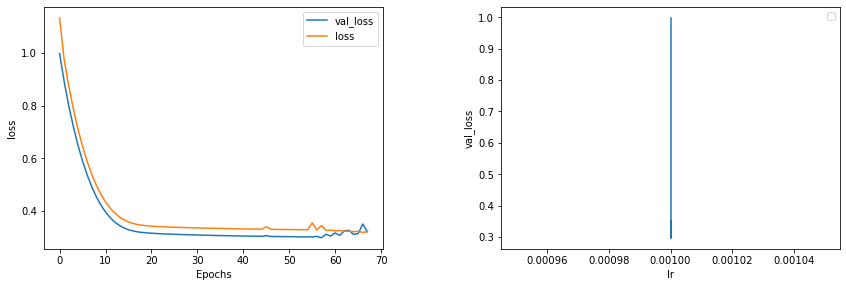

In [6]:
#Plot model history

hist = history.history

plt.figure(figsize=(13, 9))


for label in ['val_loss','loss']:
    plt.subplot(221)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")

plt.subplot(222)
plt.plot( hist['lr'],hist['val_loss']  )
plt.legend()
plt.xlabel("lr")
plt.ylabel("val_loss")
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

In [7]:
#Statistical characteristics of tasks

threshold = 0.5

prediction_train = model.predict(train_dataset)
prediction_train = np.where(prediction_train > threshold, 1.0,0.0)
prediction_val = model.predict(val_dataset)
prediction_val = np.where(prediction_val > threshold, 1.0,0.0)
prediction_test = model.predict(test_dataset)
prediction_test = np.where(prediction_test > threshold, 1.0,0.0)


for index1 in range(prediction_train.shape[1]):
    
    a = pd.DataFrame(y_train[:,index1],prediction_train[:,index1]) 
    a['y'] = a.index
    b = a.dropna()
    confusion = SK.confusion_matrix(b["y"], b[0])
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    
    for index2 in range(prediction_val.shape[1]):
        
        a_val = pd.DataFrame(y_val[:,index2],prediction_val[:,index2]) 
        a_val['y'] = a_val.index
        b_val = a_val.dropna()
        confusion_val = SK.confusion_matrix(b_val["y"], b_val[0])
        #[row, column]
        TP_val = confusion_val[1, 1]
        TN_val = confusion_val[0, 0]
        FP_val = confusion_val[0, 1]
        FN_val = confusion_val[1, 0]

        
        for index3 in range(prediction_test.shape[1]):
            
            a_test = pd.DataFrame(y_test[:,index3],prediction_test[:,index3]) 
            a_test['y'] = a_test.index
            b_test = a_test.dropna()
            confusion_test = SK.confusion_matrix(b_test["y"], b_test[0])
            #[row, column]
            TP_test = confusion_test[1, 1]
            TN_test = confusion_test[0, 0]
            FP_test = confusion_test[0, 1]
            FN_test = confusion_test[1, 0]

            
            if index1 == index2 and index1 == index3:
                
                print(("Results for task {} (training)").format(index1+1))
                print("ACC\t%.2f" % ((TN+TP)/(TN+TP+FN+FP)))
                print("MCC\t%.2f" % SK.matthews_corrcoef(b["y"], b[0]))
                print("kappa\t%.2f" % SK.cohen_kappa_score(b["y"], b[0]))
                print("SE\t%.2f" % (TP/(TP+FN)))
                print("SP\t%.2f" % (TN/(TN+FP)))
                print("PPV\t%.2f" % (TP/(TP+FP)))
                print("NPV\t%.2f" % (TN/(TN+FN)))
                print("TPR\t%.2f" %(TP/(TP+FN)))
                print("FPR\t%.2f" %(FP/(FP+TN)))
                print("F1\t%.2f" % SK.f1_score(b["y"], b[0]))   
                
                print(("Results for task {} (validation)").format(index2+1))
                print("ACC\t%.2f" % ((TN_val+TP_val)/(TN_val+TP_val+FN_val+FP_val)))
                print("MCC\t%.2f" % SK.matthews_corrcoef(b_val["y"], b_val[0]))
                print("kappa\t%.2f" % SK.cohen_kappa_score(b_val["y"], b_val[0]))
                print("SE\t%.2f" % (TP_val/(TP_val+FN_val)))
                print("SP\t%.2f" % (TN_val/(TN_val+FP_val)))
                print("PPV\t%.2f" % (TP_val/(TP_val+FP_val)))
                print("NPV\t%.2f" % (TN_val/(TN_val+FN_val)))
                print("TPR\t%.2f" %(TP_val/(TP_val+FN_val)))
                print("FPR\t%.2f" %(FP_val/(FP_val+TN_val)))
                print("F1\t%.2f" % SK.f1_score(b_val["y"], b_val[0]))
                
                print(("Results for task {} (test)").format(index3+1))
                print("ACC\t%.2f" % ((TN_test+TP_test)/(TN_test+TP_test+FN_test+FP_test)))
                print("MCC\t%.2f" % SK.matthews_corrcoef(b_test["y"], b_test[0]))
                print("kappa\t%.2f" % SK.cohen_kappa_score(b_test["y"], b_test[0]))
                print("SE\t%.2f" % (TP_test/(TP_test+FN_test)))
                print("SP\t%.2f" % (TN_test/(TN_test+FP_test)))
                print("PPV\t%.2f" % (TP_test/(TP_test+FP_test)))
                print("NPV\t%.2f" % (TN_test/(TN_test+FN_test)))
                print("TPR\t%.2f" %(TP_test/(TP_test+FN_test)))
                print("FPR\t%.2f" %(FP_test/(FP_test+TN_test)))
                print("F1\t%.2f" % SK.f1_score(b_test["y"], b_test[0]))

3/3 [==============================] - 0s 9ms/step
Results for task 1 (training)
ACC	0.91
MCC	0.00
kappa	0.00
SE	nan
SP	0.91
PPV	0.00
NPV	1.00
TPR	nan
FPR	0.09
F1	0.00
Results for task 1 (validation)
ACC	0.92
MCC	0.00
kappa	0.00
SE	nan
SP	0.92
PPV	0.00
NPV	1.00
TPR	nan
FPR	0.08
F1	0.00
Results for task 1 (test)
ACC	0.92
MCC	0.00
kappa	0.00
SE	nan
SP	0.92
PPV	0.00
NPV	1.00
TPR	nan
FPR	0.08
F1	0.00


C:\Users\Predator\AppData\Local\Temp\ipykernel_16100\1475257062.py:58: RuntimeWarning: invalid value encountered in longlong_scalars
  print("SE\t%.2f" % (TP/(TP+FN)))
C:\Users\Predator\AppData\Local\Temp\ipykernel_16100\1475257062.py:62: RuntimeWarning: invalid value encountered in longlong_scalars
  print("TPR\t%.2f" %(TP/(TP+FN)))
C:\Users\Predator\AppData\Local\Temp\ipykernel_16100\1475257062.py:70: RuntimeWarning: invalid value encountered in longlong_scalars
  print("SE\t%.2f" % (TP_val/(TP_val+FN_val)))
C:\Users\Predator\AppData\Local\Temp\ipykernel_16100\1475257062.py:74: RuntimeWarning: invalid value encountered in longlong_scalars
  print("TPR\t%.2f" %(TP_val/(TP_val+FN_val)))
C:\Users\Predator\AppData\Local\Temp\ipykernel_16100\1475257062.py:82: RuntimeWarning: invalid value encountered in longlong_scalars
  print("SE\t%.2f" % (TP_test/(TP_test+FN_test)))
C:\Users\Predator\AppData\Local\Temp\ipykernel_16100\1475257062.py:86: RuntimeWarning: invalid value encountered in longl

IndexError: index 1 is out of bounds for axis 1 with size 1